# Chatbot

Options :

In [1]:
train_model = True
#train_model = False

In [2]:
api = False
#api = True

In [3]:
#test = False
test = False

Importer les modules nécessaires :

In [4]:
import json
import pandas as pd
from nltk.stem.snowball import FrenchStemmer, EnglishStemmer
from nltk.corpus import stopwords
from langdetect import detect_langs
import unicodedata
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import random
import numpy as np

from flask import Flask, render_template, request

import pickle

Obtenir la DataFrame à partir de ``content.json`` :

In [5]:
#ouvrir le fichier JSON
from API.connecteur import Connecteur

In [6]:
data1 = Connecteur.get_all_data()

In [7]:
#créer les listes vides
tags = []
inputs = []
responses={}
#les remplir avec le contenu du JSON
for intent in data1['intents']:
  responses[intent['tag']]=intent['liste_output']
  for lines in intent['liste_input']:
    inputs.append(lines)
    tags.append(intent['tag'])
    
#convertir en DataFrame
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

#mélanger aléatoirement
data = data.sample(frac=1)

#montrer la DataFrame
display(data)
#montrer les catégories
data["tags"].value_counts()

,inputs,tags
1293,Est ce que l'école fournit une aide au logeme...,logement
1078,Does a partnership need a contract?,en_conditions
633,Partner,en_partner
104,Nous cherchons à recruter des alternants,partenaire
777,Schedule,en_pédagogie
...,...,...
1157,Do students become apprentices?,en_contrat
1422,Who to speak to about becoming a partner?,en_adresser
137,J’aimerai des informations,salutation
1468,Is it possible to recommend someone as a candi...,en_personne


apprenant          53
debouches          47
admission          42
en_covid           41
partenaire         38
                   ..
selection           1
contrat             1
logement            1
nombre_recruter     1
conditions          1
Name: tags, Length: 79, dtype: int64

Créer les fonctions de traitement du texte :

In [8]:
#enlever les accents du texte
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return str(only_ascii)[2:-1]

In [9]:
#définir les stopwords
stop_words_en = list(set(stopwords.words('english')))
stop_words_fr = list(set(stopwords.words('french')))

#rajouter aux stopwords français leurs versions sans accents
stop_words_fr_1 = []
for word in stop_words_fr:
    word = remove_accents(word)
    stop_words_fr_1.append(word)
stop_words_fr = list(sorted(set(stop_words_fr + stop_words_fr_1)))

In [10]:
#traiter le texte
def treatment(text):
    #vérifier si c'est une question
    if text[-1] == "?":
        question = "?"
    else:
        question = "0"
        
    #vérifier la langue
    language_list = detect_langs(text)
    language_list_2 = []
    for language in language_list:
        language = str(language).split(":")[0]
        language_list_2.append(language)
    if "fr" in language_list_2:
        language = "francais"
    elif "en" in language_list_2:
        language = "anglais"
    else:
        language = "francais"
    
    #segmenter le texte et traiter chaque mot et chaque lettre
    text = text.split()
    words_list = []
    for word in text:
        letters_list = []
        for character in word:
            #vérifier que le caractère est une lettre
            if character.isalpha():
                #rajouter à la liste en minuscule
                letters_list.append(character.lower())
            else:
                letters_list.append(" ")
        word = "".join(letters_list)
        
        #appliquer le stemming suivant la langue
        for word1 in word.split():
            word_yes = False
            if language == "anglais":
                if word1 not in stop_words_en:
                    word1 = EnglishStemmer().stem(word1)
                    word_yes = True
            else:
                if word1 not in stop_words_fr:
                    word1 = FrenchStemmer().stem(word1)
                    word_yes = True
            #enlever les accents
            if word_yes == True:
                word1 = remove_accents(word1)
                words_list.append(word1)
            
    #joindre en une string
    text = " ".join(words_list)
    return " ".join([text, question, language])
    #pour avoir en trois colonnes
    #return [text, question, language]

Obtenir une colonne avec les inputs traités :

In [11]:
#pour avoir en trois colonnes

#text_list = []
#ques_list = []
#lang_list = []

#for value in data["inputs"]:
    #value = treatment(value)
    #text_list.append(value[0])
    #ques_list.append(value[1])
    #lang_list.append(value[2])

#data["text"] = text_list
#data["?"] = ques_list
#data["language"] = lang_list

In [12]:
data["texts"] = data["inputs"].apply(treatment)

In [13]:
data

,inputs,tags,texts
1293,Est ce que l'école fournit une aide au logeme...,logement,ecol fourn aid log appren ? francais
1078,Does a partnership need a contract?,en_conditions,partnership need contract ? anglais
633,Partner,en_partner,partn 0 francais
104,Nous cherchons à recruter des alternants,partenaire,cherchon recrut altern 0 francais
777,Schedule,en_pédagogie,schedul 0 francais
...,...,...,...
1157,Do students become apprentices?,en_contrat,do student becom apprentic ? francais
1422,Who to speak to about becoming a partner?,en_adresser,speak becom partner ? anglais
137,J’aimerai des informations,salutation,aim inform 0 francais
1468,Is it possible to recommend someone as a candi...,en_personne,possibl recommend someon candid ? anglais


Appliquer le tokenizer sur les inputs traités :

In [14]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['texts'])
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

train = tokenizer.texts_to_sequences(data['texts'])
#apply padding
x_train = pad_sequences(train)

In [15]:
x_train

array([[  0,   0,   0, ..., 345,  10,   2],
       [  0,   0,   0, ...,  16,  50,   1],
       [  0,   0,   0, ..., 168,   3,   2],
       ...,
       [  0,   0,   0, ..., 151,   3,   2],
       [  0,   0,   0, ...,  66, 124,   1],
       [  0,   0,   0, ..., 616,   3,   2]])

Appliquer LabelEncoder() sur les tags :

In [16]:
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

with open('labelencoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
input_shape = x_train.shape[1]
print(input_shape)

11


In [18]:
vocabulary = len(tokenizer.word_index)
print("Nombre de mots uniques : ",vocabulary)
output_length = le.classes_.shape[0]
print("Taille des outputs : ",output_length)

Nombre de mots uniques :  616
Taille des outputs :  79


### Validation (Validation split)

In [19]:
#longueur d'1/5 du Dataset
prod=int(len(x_train)* 0.2)

#séparation en x_val et x_train
x_val=x_train[-prod:, :]
x_train=x_train[:-prod, :]

In [20]:
#séparation en y_val et y_train
y_val=y_train[ -prod:]
y_train=y_train[:-prod]

In [21]:
display(x_val.shape,x_train.shape,y_val.shape,y_train.shape)

(299, 11)

(1196, 11)

(299,)

(1196,)

Créer et entraîner le modèle :

In [22]:
if train_model == True:
    #créer le modèle
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Embedding(vocabulary+1, 10))
    model.add(Bidirectional(LSTM(40, return_sequences=True)))
    #model.add(Bidirectional(LSTM(20)))
    model.add(Flatten())
    model.add(Dense(output_length, activation="softmax"))
    
    
    
    #i = Input(shape=(input_shape,))
    #x = Embedding(vocabulary+1,10)(i)
    #x = Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10))(x)
    #x = Bidirectional(LSTM(10))(x)
    #x = Flatten()(x)
    #x = Dense(output_length,activation="softmax")(x)
    #model  = Model(i,x)

    #compiler le modèle
    model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

    #enregistrer le modèle à son meilleur résultat
    model_name = "model.h5"

    modelcheckpoint = ModelCheckpoint(model_name,
                                      monitor='val_loss',
                                      mode='auto',
                                      verbose=1,
                                      save_best_only=True)
    lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1)
    

    callback_list = [modelcheckpoint, lr_scheduler]
    
    #entraîner le modèle
    history = model.fit(x_train,y_train,epochs=100, validation_data=(x_val, y_val), callbacks=callback_list)
    clear_session()

Epoch 1/100
38/38 [==============================] - 9s 94ms/step - loss: 4.3195 - accuracy: 0.0238 - val_loss: 4.1051 - val_accuracy: 0.0301

Epoch 00001: val_loss improved from inf to 4.10506, saving model to model.h5
Epoch 2/100
38/38 [==============================] - 0s 10ms/step - loss: 4.0349 - accuracy: 0.0388 - val_loss: 4.0137 - val_accuracy: 0.0368

Epoch 00002: val_loss improved from 4.10506 to 4.01373, saving model to model.h5
Epoch 3/100
38/38 [==============================] - 0s 10ms/step - loss: 3.8661 - accuracy: 0.0701 - val_loss: 3.6141 - val_accuracy: 0.0870

Epoch 00003: val_loss improved from 4.01373 to 3.61414, saving model to model.h5
Epoch 4/100
38/38 [==============================] - 0s 11ms/step - loss: 3.5126 - accuracy: 0.0838 - val_loss: 3.4853 - val_accuracy: 0.0970

Epoch 00004: val_loss improved from 3.61414 to 3.48533, saving model to model.h5
Epoch 5/100
38/38 [==============================] - 0s 11ms/step - loss: 3.3266 - accuracy: 0.1291 - val_lo

38/38 [==============================] - 0s 10ms/step - loss: 0.1270 - accuracy: 0.9732 - val_loss: 2.0861 - val_accuracy: 0.6957

Epoch 00039: val_loss did not improve from 1.96564
Epoch 40/100
38/38 [==============================] - 0s 10ms/step - loss: 0.1202 - accuracy: 0.9703 - val_loss: 2.1082 - val_accuracy: 0.6890

Epoch 00040: val_loss did not improve from 1.96564
Epoch 41/100
38/38 [==============================] - 0s 12ms/step - loss: 0.1345 - accuracy: 0.9693 - val_loss: 2.1022 - val_accuracy: 0.6990

Epoch 00041: val_loss did not improve from 1.96564
Epoch 42/100
38/38 [==============================] - 0s 10ms/step - loss: 0.1207 - accuracy: 0.9752 - val_loss: 2.1133 - val_accuracy: 0.6890

Epoch 00042: val_loss did not improve from 1.96564

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 43/100
38/38 [==============================] - 0s 10ms/step - loss: 0.1290 - accuracy: 0.9682 - val_loss: 2.1168 - val_accuracy: 0.6789

Epoch 00


Epoch 00078: val_loss did not improve from 1.96564
Epoch 79/100
38/38 [==============================] - 0s 10ms/step - loss: 0.1021 - accuracy: 0.9821 - val_loss: 2.1533 - val_accuracy: 0.7023

Epoch 00079: val_loss did not improve from 1.96564
Epoch 80/100
38/38 [==============================] - 0s 10ms/step - loss: 0.0895 - accuracy: 0.9857 - val_loss: 2.1537 - val_accuracy: 0.7057

Epoch 00080: val_loss did not improve from 1.96564
Epoch 81/100
38/38 [==============================] - 0s 10ms/step - loss: 0.0866 - accuracy: 0.9876 - val_loss: 2.1543 - val_accuracy: 0.6990

Epoch 00081: val_loss did not improve from 1.96564
Epoch 82/100
38/38 [==============================] - 0s 10ms/step - loss: 0.0903 - accuracy: 0.9862 - val_loss: 2.1537 - val_accuracy: 0.7057

Epoch 00082: val_loss did not improve from 1.96564
Epoch 83/100
38/38 [==============================] - 0s 10ms/step - loss: 0.0939 - accuracy: 0.9862 - val_loss: 2.1537 - val_accuracy: 0.7057

Epoch 00083: val_loss di

Faire une prédiction sur ``x_val`` :

In [23]:
#obtenir les arguments pour chaque ligne
y_pred=model.predict(x_val)

In [24]:
#récupérer l'argument maximal sur chaque ligne
y_pred_2 =[]
for pred in y_pred:
    y_pred_2.append(pred.argmax())
y_pred_2 = np.array(y_pred_2)
y_pred_2

array([16, 22, 30,  4, 56, 69, 46, 55,  7, 26, 17, 46, 20, 45, 31, 20,  4,
       54, 44, 48, 14, 14,  5,  2, 25, 40,  7, 40, 48, 20,  0, 34, 19, 25,
        5, 78, 54, 55, 26, 69, 53, 20, 35, 14, 77,  4, 27, 55, 19, 23, 71,
       26, 35, 14, 31, 18, 64, 20, 22, 64, 14, 22, 54, 54, 32, 36, 39, 27,
       25, 50, 38, 38, 32, 64, 16, 47,  2, 38, 74, 55, 17, 21, 41, 14,  5,
       33, 28, 45, 45, 55, 53, 14, 36, 19, 38, 16, 56, 16, 29, 41,  9, 32,
       14, 61, 26, 23, 26,  5, 19, 51, 69,  4, 20, 33, 36,  5, 17, 60, 71,
       45, 47, 19, 20, 19, 25, 20, 64,  5, 24, 69, 38, 27,  4, 21, 17, 47,
       24, 17,  5, 16, 77,  3, 55, 61, 46, 21, 54, 49, 22, 49, 46, 28, 21,
       64,  5, 23, 22, 32, 54, 41, 77,  9, 68, 17, 39, 34, 55,  5, 51, 35,
       51, 21,  0, 23,  4, 55, 19, 35, 24, 44, 41, 69, 54, 31, 50, 25,  2,
        7,  0, 42, 28, 77, 43, 23, 69, 61, 20, 55, 19, 44,  5, 29, 27, 45,
       63,  3, 20, 35, 43,  2, 54, 77, 45, 38, 29, 64, 27, 48, 15,  7,  2,
       51, 19, 38, 27, 14

faire une matrice de confusion pour comparer y_train de y_val

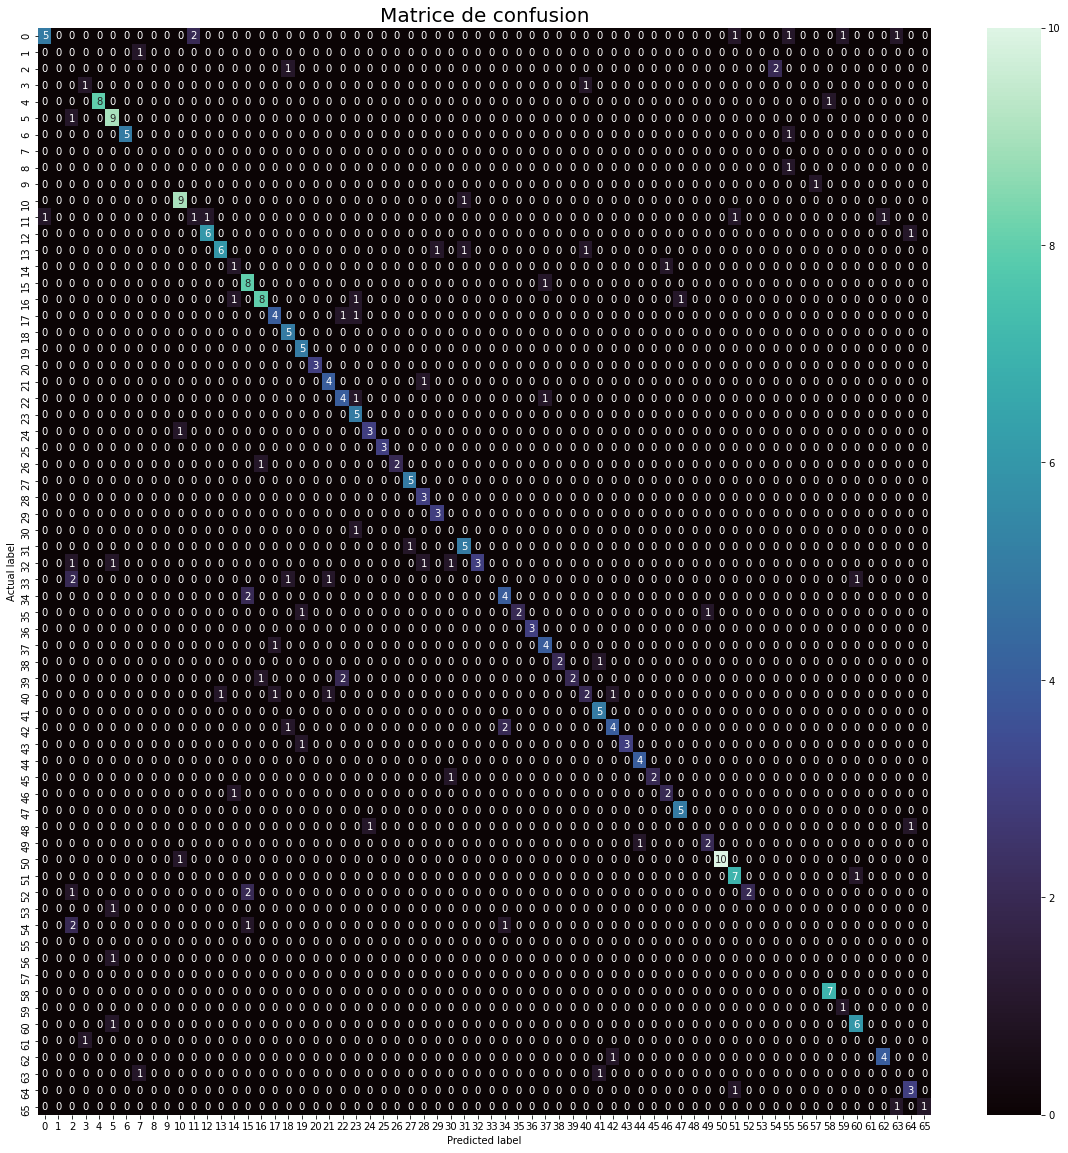

In [25]:
import seaborn as sns

cm = confusion_matrix(y_val , y_pred_2)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt=".0f", cmap = 'mako')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Matrice de confusion", size = 20)
plt.show()

### Historique

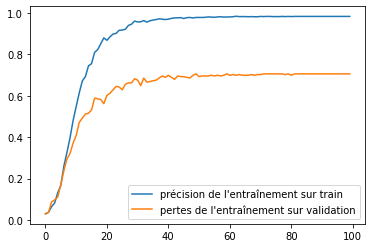

In [26]:
if train_model == True:
    #montrer l'historique de précision et des pertes
    plt.plot(history.history['accuracy'],label="précision de l'entraînement sur train")
    plt.plot(history.history['val_accuracy'],label="pertes de l'entraînement sur validation")
    plt.legend()

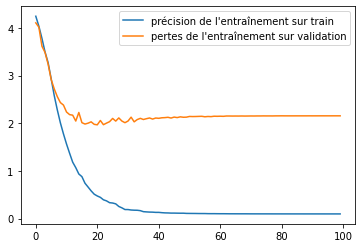

In [27]:
if train_model == True:
    #montrer l'historique de précision et des pertes
    plt.plot(history.history['loss'],label="précision de l'entraînement sur train")
    plt.plot(history.history['val_loss'],label="pertes de l'entraînement sur validation")
    plt.legend()

In [28]:
if train_model == False:
    model = load_model("model_py/model.h5")

## Test

Taper 0 pour sortir.

In [29]:
if test == True:
    while True:
      texts_p = []
      prediction_input = input('Vous : ')
      if prediction_input == "0":
        break

      #appliquer la fonction treatment
      prediction_input = treatment(prediction_input)
      texts_p.append(prediction_input)
      print(prediction_input)

      #tokenizer et padding
      prediction_input = tokenizer.texts_to_sequences(texts_p)
      prediction_input = np.array(prediction_input).reshape(-1)
      prediction_input = pad_sequences([prediction_input],input_shape)
      print(prediction_input)

      #obtenir la prédiction du modèle
      output = model.predict(prediction_input)
      output = output.argmax()
      print(output)

      #trouver la tag correspondante et la réponse
      response_tag = le.inverse_transform([output])[0]
      print(response_tag)
      #print("Chatbot : ",random.choice(responses[response_tag]))
      if response_tag == "goodbye":
        break

## API

In [30]:
if api == True:
    app = Flask(__name__)

    s_list = ["inconnu", "apprenant", "partenaire"]
    user_status = s_list[0]

    #créer deux listes de tags identifiant l'utilisateur comme étant apprenant ou partenaire
    appr_list = []
    part_list = []

    #créer deux dictionnaires avec les équivalents d'output apprenant/partenaire
    to_appr = {}
    to_part = {}


    #definir les app.route
    @app.route("/")
    def index():
        return render_template("index.html")

    @app.route("/get")
    #fonction de réponse
    def get_bot_response():
        #obtenir la question et la formatter
        texts_p = []
        prediction_input = request.args.get('msg')
        prediction_input = treatment(prediction_input)
        texts_p.append(prediction_input)

        #formatter l'input
        prediction_input = tokenizer.texts_to_sequences(texts_p)
        prediction_input = np.array(prediction_input).reshape(-1)
        prediction_input = pad_sequences([prediction_input],input_shape)

        #prédire l'output
        output = model.predict(prediction_input)
        output = output.argmax()

        #vérifier si l'output identifie l'utilisateur
        if output in appr_list:
            user_status = s_list[1]
        elif output in part_list:
            user_status = s_list[2]

        #si l'utilisateur est identifié et l'output est susceptible de changer pour ça, alors le changer
        if user_status == s_list[1] and output in to_appr.keys():
            output = to_appr[output]
        elif user_status == s_list[2] and output in to_part.keys():
            output = to_part[output]

        #transformer la réponse et la renvoyer
        response_tag = le.inverse_transform([output])[0]
        response = str("Chatbot : ",random.choice(responses[response_tag]))
        return response

    #lancer l'API
    if __name__ == "__main__":
        app.run()